# Posterior and Marginal distributions

This notebook is the continuation of `bandwidths.ipynb` notebook, apliying the bw results and the class for get the n-dimentional PDF. 

#### Some considerations: 
1. As **prior** information we will take the cleaned (without NaN or inf values) information from exoplanet.eu, this is the first part of notebook.

2. The PDF from `oiptimal_pdf` class  fulfills the functions of **likelihood** for a certain number of variables in synthetic systems with no-pertutbation, low perturbation and high perturbation. 

3. To get the **marginal** distributions of a variable of interest, we go in the same way that the example marginalization in the notebook `3D.ipynb`.

In [40]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

In [41]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## 1. Data Cleaning

### 1.1 Simulation data   

see the notation according to <a href="https://github.com/saint-germain/population_synthesis/blob/master/README.md ">Readme.md</a> from `Population_synthesis` project.





In [42]:
#========================== Simulation Data ==========================
dn=pd.read_csv('data/proc_no_pert.csv',index_col=None); dn["gia"]=dn.ngi>0 #without pertubtations 
dl=pd.read_csv('data/proc_lo_pert.csv',index_col=None); dl["gia"]=dl.ngi>0 #with low pertubtations 
dh=pd.read_csv('data/proc_hi_pert.csv',index_col=None); dh["gia"]=dh.ngi>0 #with high pertubtations

In [43]:
#======================= Simulation variables ========================
##Terrestrial: t; giant;g
dnt=dn[~dn["gia"]]; dng=dn[dn["gia"]] # without pertubtations 
dlt=dl[~dl["gia"]]; dlg=dl[dl["gia"]] # low pertubtations 
dht=dh[~dh["gia"]]; dhg=dh[dh["gia"]] # high pertubtations 

x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]

for i, var in enumerate(x_variables):
    var['logeff'] = np.log10(var.massefficiency)
    var['logcom'] = np.log10(var.com)

In [44]:
dnt.head()

,Unnamed: 0,ident,com,nplanets,massbudget,massefficiency,sigmag0,md,rc,ms,metal,taugas,qest,ngi,mtr,apert,gia,logeff,logcom
1,1,5.0,2.932894,12.0,17.882769,0.000488,102.431593,0.110,38.977428,1.075269,-0.150160,1.014449e+06,5.464831,0.0,17.882769,0.0,False,-3.311837,0.467296
3,3,8.0,5.740174,9.0,8.166382,0.000163,62.737337,0.150,58.158928,1.076658,-0.282408,6.017040e+06,4.704798,0.0,8.166382,0.0,False,-3.786940,0.758925
5,5,15.0,8.394027,8.0,16.003091,0.000436,106.824759,0.110,38.167542,0.986003,0.388613,2.435406e+06,5.218175,0.0,16.003091,0.0,False,-3.360068,0.923970
6,6,16.0,4.289089,24.0,12.426573,0.000219,118.543720,0.170,45.042137,1.258747,-0.352459,1.107032e+06,4.469478,0.0,12.426573,0.0,False,-3.658976,0.632365
7,7,17.0,3.771156,12.0,16.762554,0.000811,35.587738,0.062,49.645451,0.739731,0.121866,9.050091e+06,7.257983,0.0,16.762554,0.0,False,-3.090930,0.576474


### 1.2 Observational data 

Data get from <a href="http://exoplanet.eu/">exoplanet.eu</a>

In [45]:
data_o = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                       usecols = ['mass','mass_error_min','semi_major_axis','semi_major_axis_error_min','star_name',
                                  'star_metallicity','star_metallicity_error_min','star_mass','star_mass_error_min'])

data_o = data_o.replace([np.inf, -np.inf], np.nan) 
data_o = data_o.replace([0], np.nan)
data_o = data_o.dropna()

In [46]:
data_o = data_o[['star_name','mass','mass_error_min', 'semi_major_axis', 'semi_major_axis_error_min', 
                 'star_metallicity', 'star_metallicity_error_min', 'star_mass', 'star_mass_error_min']]

data_o = data_o.assign(CM_i = data_o["semi_major_axis"]*data_o["mass"])
data_o = data_o.assign(dCM_i= data_o["CM_i"]*(data_o["mass_error_min"].divide(data_o["mass"])+data_o["semi_major_axis_error_min"].divide(data_o["semi_major_axis"])))

In [47]:
number=(data_o["star_name"].value_counts()).to_frame()

In [48]:
def NewData(data):
   
    p_system = data.groupby("star_name")
    
    Mtp   = p_system['mass'].sum();             dMtp   = p_system['mass_error_min'].sum();  
    ms    = p_system['star_mass'].mean();        dms    = p_system['star_mass_error_min'].mean()
    metal = p_system['star_metallicity'].mean(); dmetal = p_system['star_metallicity_error_min'].mean()
    
    
    CoM  = p_system['CM_i'].sum().divide(p_system["mass"].sum())
    dCoM = CoM*((p_system['dCM_i'].sum()/p_system['CM_i'].sum()) + (p_system['mass_error_min'].sum())/p_system['mass'].sum())
    
    NewData = pd.DataFrame({'sys_name':list(p_system.groups.keys()),
                            'Mtp':Mtp, 'dMtp':dMtp,
                            'com':CoM.tolist(), 'dcom':dCoM.tolist(), 
                            'ms':ms, 'dms':dms, 'metal':metal, 'dmetal':dmetal})
    return NewData

In [50]:
obs_data = NewData(data_o)
obs_data = obs_data.assign(n_planets = number)
obs_data = obs_data.sort_values(by=['n_planets'], ascending=False)
obs_data.head()

,sys_name,Mtp,dMtp,com,dcom,ms,dms,metal,dmetal,n_planets
star_name,,,,,,,,,,
TRAPPIST-1,TRAPPIST-1,0.017701,0.010374,0.029040,0.034407,0.080,0.007,0.04,0.08,7
K2-138,K2-138,0.113900,0.030500,0.083596,0.053756,0.930,0.060,0.16,0.04,6
GJ 876,GJ 876,2.861000,0.045000,0.185302,0.005413,0.334,0.030,0.05,0.20,4
WASP-47,WASP-47,2.511800,0.097400,0.760462,0.220362,1.110,0.490,0.18,0.07,4
Kepler-289,Kepler-289,0.451000,0.077000,0.489512,0.184174,1.080,0.020,0.05,0.04,3


In [51]:
#system_i = data_o[data_o.star_name == "Kepler-289"]  
#system_i

## 2. Posterior probability 

### 2.1 Likelihood

In [59]:
import nbimporter
from bandwidths import optimal_pdf #import the class for get the pdf.

In this example we take the variables `dng.ms`, `dng.metal` and `dng.nplanets` 

In [60]:
likel = optimal_pdf(dng.ms, dng.metal, dng.nplanets)
likel.pdf()

In [61]:
likelihood = likel.pdf_std #in standard space
#likelihood

### 2.2 Prior infromation

In [62]:
def bi_norm(x, y, x_mu, x_std, y_mu, y_std):
    c = 1/(2*np.pi*x_std*y_std)
    return c*np.exp(-((x-x_mu)/x_std)**2-((y-y_mu)/y_std)**2)#.reshape(int(len(x)**2/2),2)

def tri_norm(x, y, z, x_mu, x_std, y_mu, y_std, z_mu, z_std):
    c = 1/(2*np.pi*x_std*y_std*z_std)
    return c*np.exp(-((x-x_mu)/x_std)**2-((y-y_mu)/y_std)**2-((z-z_mu)/z_std)**2)

In [71]:
systm = obs_data[obs_data.sys_name == "K2-138"] 
systm

,sys_name,Mtp,dMtp,com,dcom,ms,dms,metal,dmetal,n_planets
star_name,,,,,,,,,,
K2-138,K2-138,0.1139,0.0305,0.083596,0.053756,0.93,0.06,0.16,0.04,6


In [104]:
# prior x
x = np.linspace(systm.ms-3*systm.dms, systm.ms+3*systm.dms,100)
prior_x = stats.norm.pdf(x, loc = systm.ms, scale = systm.dms)  

In [105]:
prior_x.std()

2.324534408378037

In [111]:
systm.dms*3

star_name
K2-138    0.18
Name: dms, dtype: float64

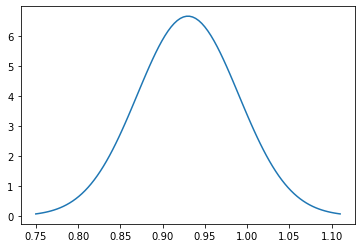

In [107]:
plt.plot(x,prior_x)

In [108]:
prior_x.mean()

2.74329182737603

In [77]:
# prior y
y = np.linspace(systm.metal-3*systm.dmetal,systm.metal+3*systm.dmetal,100)
prior_y = stats.norm.pdf(y, loc = systm.metal, scale = systm.metal)

In [78]:
prior_y

array([[1.88210895],
       [1.90340004],
       [1.92449013],
       [1.94536726],
       [1.96601948],
       [1.98643487],
       [2.00660154],
       [2.02650768],
       [2.04614152],
       [2.06549134],
       [2.08454556],
       [2.10329264],
       [2.12172119],
       [2.13981991],
       [2.15757765],
       [2.17498339],
       [2.19202627],
       [2.2086956 ],
       [2.22498084],
       [2.24087166],
       [2.25635792],
       [2.27142971],
       [2.28607729],
       [2.3002912 ],
       [2.31406218],
       [2.32738126],
       [2.34023968],
       [2.352629  ],
       [2.36454102],
       [2.37596784],
       [2.38690187],
       [2.3973358 ],
       [2.40726264],
       [2.41667573],
       [2.42556873],
       [2.43393564],
       [2.44177079],
       [2.44906887],
       [2.45582492],
       [2.46203433],
       [2.46769288],
       [2.47279669],
       [2.47734227],
       [2.4813265 ],
       [2.48474666],
       [2.4876004 ],
       [2.48988575],
       [2.491

In [20]:
systm.dms.values

array([0.06])

In [21]:
x = np.linspace(systm.ms-3*systm.dms,systm.ms+3*systm.dms,100)
y = np.linspace(systm.metal-systm.dmetal,systm.metal+systm.dmetal,100)

X,Y = np.meshgrid(x,y)

prior = bi_norm(X,Y,systm.Mtp.values, systm.dMtp.values, systm.metal.values, systm.dmetal.values)

In [22]:
prior

array([[6.02085707e-188, 4.10880810e-190, 2.72537800e-192, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [6.26654734e-188, 4.27647429e-190, 2.83659121e-192, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [6.51694179e-188, 4.44735075e-190, 2.94993380e-192, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [6.51694179e-188, 4.44735075e-190, 2.94993380e-192, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [6.26654734e-188, 4.27647429e-190, 2.83659121e-192, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [6.02085707e-188, 4.10880810e-190, 2.72537800e-192, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

In [23]:
prior_std = ((prior - np.mean(prior, axis=0))/np.std(prior, axis = 0)).reshape(X.shape)
#prior_std

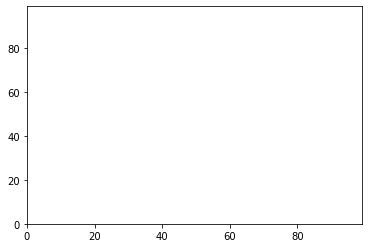

In [24]:
plt.contour(prior_std)
#prior

In [25]:
x_y = stats.norm.pdf(x)
y_y = stats.norm.pdf(y)

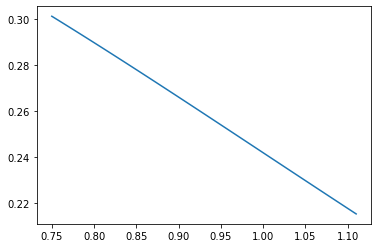

In [26]:
plt.plot(x,x_y)

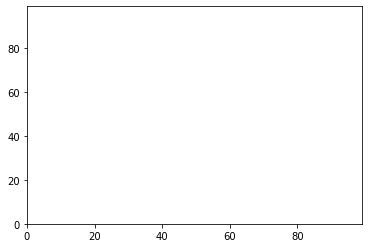

In [27]:
prior_2=((np.ones([100,100]).T*prior_y).T)*prior_x
plt.contour(prior_2)

### 2.2 Likelihood